# Lab 02 : Multi Layer Perceptron

In [27]:
import numpy

## Multilayer Perceptron Network

![image.png](img/2.png)

Source:http://www.texample.net/tikz/examples/neural-network/

Now that we have seen a single perceptron we will try to use the above concepts to make MLP network using Numpy from scratch

Now there are some building blocks that we will be using :-

 - <b>Dense Layer</b> : A fully connected Neural Net Layer.
             
               f(X) = W . X + b
               
               W : Matrix of weights
               X : Inputs
               b : Bias
               
 - <b>Activation Layer</b> : Layer to introduce non linearlity (Why is this important?)
 - <b>Loss Function</b> : (Binary or Cross Entropy Loss)
 - <b>Back Propogation Algorithm</b> : a stochastic gradient descent algortihm
 
 
 You can go through the code for the exact architecture to incoporate these blocks

In [34]:
import numpy as np
import matplotlib.pyplot as plt


### Functions for plotting graphs

In [35]:


def plot_loss(epoch_his, train_loss_his, test_loss_his):
    train_line, = plt.plot(epoch_his,train_loss_his,label = 'train')
    test_line, = plt.plot(epoch_his,test_loss_his,label = 'test')
    plt.xlabel('EPOCHS')
    plt.ylabel('Loss')
    plt.legend([train_line, test_line] , ['train','test'])
    plt.show()

def plot_accuracy(epoch_his, train_acc_his, test_acc_his):
    train_line, = plt.plot(epoch_his,train_acc_his,label = 'train')
    test_line, = plt.plot(epoch_his,test_acc_his,label = 'test')
    plt.xlabel('EPOCHS')
    plt.ylabel('Accuracy')
    plt.legend([train_line, test_line] , ['train','test'])
    plt.show()



### Activation Function

In [36]:

def relu(z):
    """
    Relu Activation
    Inputs:
    - z : A 2D numpy array
    """
    return (z > 0 ) * z

def relu_back(z):
    """
    Backpropogation for Relu Activation
    Inputs:
    - z : A 2D numpy array
    """
    return (z>0).astype(np.float64)

### Loss Function

In [37]:

def binary_cross_entropy(pred , Y):
    """
    The binary cross entropy loss.
    Note
    -pred should be in range [0,1]
    -Y should be a binary vector
    Inputs
    -pred: a numpy array reprsenting predictions made by the model
    -Y : a numpy  array representing the target variable
    Note that shape(pred) = shape(Y)
    Returns
    - loss : a scalar value to represent the loss
    - d_pred : a vector of the same shape as pred. It represents the error
            to be used for backpropogation(shape(d_pred) = shape(pred))
    """

    # clipping the inputs so there is no overflow
    epsilon = 1e-11
    pred = np.clip(pred , epsilon, 1 - epsilon)
    divisor = np.maximum(pred * (1-pred),epsilon)

    N = Y.shape[0]

    first_term = Y * np.log(pred)
    second_term = (1 - Y) * np.log(1 - pred)
    loss = -1  * np.mean( first_term + second_term ,axis =0)
    d_pred = np.nan_to_num((pred - Y) / (divisor * float(N)))

    return loss,d_pred

### Metric Function

In [38]:

def accuracy_binary(pred , Y):
    """
    Computes the zero one accuracy for a binary classificatiion
    Inputs:
    -pred: Column vector representing probabilities of Class == 1
    -Y: Binary column vector
    """
    pred =pred > 0.5
    acc = np.sum(pred == Y)
    acc = float(acc) / len(Y)
    return acc

 <b> We will first implement a Perceptron Layer Class</b>

In [39]:
class PerceptronLayer:
    """
    A fully connected layer for a neural network with RelU activation.
    This will be used to make a MultiLayerPerceptron that uses modular design.
    (The neural network architecture is defined by the user.)
    Note that this class does not implement any learning function. This class
    is to initialize layers in a multi layer perceptron model efficiently.
    The learnable parameters of the model are stored in as variables _self.W_,_self.b_
    """

    def __init__(self,l0,l1):
        """
        Initialize a layer of the network
        Inputs:
         - l0: an integer giving size of the input i.e. the size of previous layer
         - l1: an integer giving size of the output i.e the size of layer
         - activation: a string giving activation function of this layer
                    (default value:'linear')
        """
        self.W = np.random.randn(l0 ,l1).astype(np.float64)# * np.sqrt(2.0 /l0 )
        self.b = np.zeros((l1)).astype(np.float64)

        # self.grad = {'W':np.zeros((l0,l1)).astype(np.float64) ,
        #             'b':np.zeros((l1)).astype(np.float128) }

        self.act_fn = relu
        self.act_fn_back = relu_back

        print(self.W.shape , self.b.shape)
        print(self.act_fn)

    def forward(self,X):
        """
        This function performs the Forward propogation of a layer
        """

        #print(X.shape , self.W.shape , self.b.shape)
        h_x = X.dot(self.W) + self.b

        a = self.act_fn(h_x)
        # print(a)
        return a,h_x



    def update_batch_gradient_descent(self , X , h_x , d_back,alpha = 0.01):
        """
        This function performs the weight update of a layer using the Gradient descent optimizer
        Inputs:
        - X : The input to the layer
        - h_x : The predicted output of the layer
        - d_back : Gradients from front layers calculated using backpropogation
        - alpha : The learning rate (Default : 0.01)
        """

        # dloss/d(a) * d(a) / d(h_x)
        
        d_h_x = self.act_fn_back(h_x) * d_back
        #Derivating w.r.t W
        # dloss/d(h_x) * d(h_x) / d(W)
        # print((d_h_x).shape)

        d_W = X.T.dot(d_h_x)

        #Derivatng w.r.t b
        # dloss/d(h_x) * d(h_x) / d(b)
        d_b = d_h_x

        #Derivating w.r.t x(to return to previous layers)
        # dloss/d(h_x) * d(h_x) / d(X)
        d_X = d_h_x.dot(self.W.T)

        #Update W
        #print("W_before = ", self.W)
        delta_W = d_W
        self.W = self.W - alpha * delta_W
        #print("W_after = ",self.W)

        #Update b
        delta_b = np.sum(d_b , axis =0)
        self.b = self.b - alpha * delta_b

        d_back = d_X
        
        return d_back


In [40]:

class MultiLayerPerceptron:
    """
    This is the class for making a multi-layer neural network by using the PerceptronLayer class
    """

    def __init__(self ,layer_list = None):
        """
        Initialize the neural networks by creating objects of the PerceptronLayer class
        Inputs:
         - layer_list: list of layer sizes
         - activation_list: list of activation functions for each layer
        """

        if layer_list == None:
            raise Exception('layer_list cant be empty')
        
        self.hidden_layers= len(layer_list) - 1

        self.layers = {}
        
        for i in range(self.hidden_layers):
            self.layers[i+1] = PerceptronLayer(layer_list[i] , layer_list[i+1])


    def forward(self , X):
        """
        This function performs the forward propogation on the neural network
        Inputs:
        - X : Input to the neural network
        """

        a = X
        cache = []
        cache.append(a)
        for i in range(self.hidden_layers):
            a,h_x = self.layers[i+1].forward(a)
            cache.append(h_x)

        return a,cache

    def update_gradient(self, cache, d_back , alpha=0.01):
        """
        This function performs backpropogation and uses the Gradient descent optimizer for updating weights
        Inputs :
        - cache : The values required for backpropogation corresponing to a layer
        - d_back : The gradients from front layers during backpropogation
        - alpha : the learningrate (default : 0.01)
        """

        for i in range(self.hidden_layers , 0 , -1):
            
            d_back = self.layers[i].update_batch_gradient_descent(cache[i-1],cache[i],d_back,alpha)

        return d_back


    def train(self,
            X_train,
            Y_train,
            X_test,
            Y_test,
            metric_fn = accuracy_binary,
            loss_fn = binary_cross_entropy,
            epochs=200,
            record_at = 100,
            verbose = True,
            learning_rate =0.1,
            learning_rate_decay = False):

        """
        This function trains the neural network
        Inputs:
        - X_train : The training dataset
        - Y_train : The training target values
        - X_test : The testing dataset
        - Y_test : The testing target values
        - metric : The metric function for assesing the model (default : accuracy_binary)
        - loss_function_string : The loss function (default : mean_square_error)
        - epochs : The number of epochs for which the model will be trained (default : 200)
        - record_at :  The epoch interval at which the loss and metric will be recorded (default : 100)
        - Verbose : Display the statistics, metrics and progress of the model while training (default : True)
        - learning_rate : the learning rate (default : 0.1)
        - learning_rate_decay : Decaying the learning rate (default : False)
        """
        


        
        train_loss_his = []
        train_acc_his = []
        test_loss_his = []
        test_acc_his = []
        epoch_his = []

        for i in range(epochs):
            prediction , cache = self.forward(X_train)
            
            
            loss,d_back= loss_fn(prediction,Y_train)
            self.update_gradient(cache,d_back,learning_rate)
            if learning_rate_decay:
                learning_rate *= (1.0 / 1.0 + i)



            if i % record_at == 0:
                train_loss,_ = loss_fn(prediction,Y_train)
                train_acc = metric_fn(prediction,Y_train)

                test_prediction , _ = self.forward(X_test)
                test_loss,_ = loss_fn(test_prediction,Y_test)
                test_acc = metric_fn(test_prediction,Y_test)

                train_loss_his.append(train_loss)
                train_acc_his.append(train_acc)
                test_loss_his.append(test_loss)
                test_acc_his.append(test_acc)
                epoch_his.append(i)

                if verbose:
                    print("{}th EPOCH:\nTraining Loss:{}|Training Accuracy:{}|Test Loss:{}|Test Accuracy:{}".\
                      format(i , train_loss , train_acc,test_loss,test_acc))
        train_loss_his = np.array(train_loss_his).reshape(-1)
        train_acc_his = np.array(train_acc_his).reshape(-1)
        test_loss_his = np.array(test_loss_his).reshape(-1)
        test_acc_his = np.array(test_acc_his).reshape(-1)
        epoch_his = np.array(epoch_his).reshape(-1)
        return train_loss_his,train_acc_his,test_loss_his,test_acc_his,epoch_his
     
    def metric_function(self,X,Y,metric_fn=accuracy_binary):
        
        prediction , _ = self.forward(X)
        acc = metric_fn(prediction,Y)
        return acc

In [41]:
#############################################
## Declaring Training Data        ############
#############################################

# this is just for testing the MLP model that we have made [XOR DATA]
X_train = np.array([[0,0],[1,0],[0,1],[1,1]])
Y_train = np.array([[1],[0],[0],[0]])



In [68]:
X_train.shape

(4, 2)

In [69]:
Y_train.shape

(4, 1)

In [42]:
# Declare a neuron with shape of weights as [shape_of_input,1]
model = MultiLayerPerceptron([2,1])

(2, 1) (1,)
<function relu at 0x7f0cbafdcae8>


In [43]:
# testing the model outputs
pred, _ = model.forward(X_train)

In [44]:
#Testing the model before training

loss,d_back = binary_cross_entropy(pred,Y_train)
print("The loss is {}\nAnd the error to be back propogated is:\n {}".format(loss , d_back))

The loss is [19.0047374]
And the error to be back propogated is:
 [[-2.50000000e+10]
 [ 2.49999979e+10]
 [ 2.58553490e-01]
 [ 2.49999979e+10]]


In [47]:
# Now we can train the model by iteratively on each datapoint.
layer_list = [2,3,1]

model = MultiLayerPerceptron(layer_list)



train_loss_his,train_acc_his,test_loss_his,test_acc_his,epoch_his=model.train(X_train,
            Y_train,
            X_train,
            Y_train,
            metric_fn = accuracy_binary,
            loss_fn=binary_cross_entropy,
            epochs=1000,
            record_at=100)

(2, 3) (3,)
<function relu at 0x7f0cbafdcae8>
(3, 1) (1,)
<function relu at 0x7f0cbafdcae8>
0th EPOCH:
Training Loss:[6.69360651]|Training Accuracy:0.5|Test Loss:[6.33210901]|Test Accuracy:0.75
100th EPOCH:
Training Loss:[6.33210901]|Training Accuracy:0.75|Test Loss:[6.33210901]|Test Accuracy:0.75
200th EPOCH:
Training Loss:[6.33210901]|Training Accuracy:0.75|Test Loss:[6.33210901]|Test Accuracy:0.75
300th EPOCH:
Training Loss:[6.33210901]|Training Accuracy:0.75|Test Loss:[6.33210901]|Test Accuracy:0.75
400th EPOCH:
Training Loss:[6.33210901]|Training Accuracy:0.75|Test Loss:[6.33210901]|Test Accuracy:0.75
500th EPOCH:
Training Loss:[6.33210901]|Training Accuracy:0.75|Test Loss:[6.33210901]|Test Accuracy:0.75
600th EPOCH:
Training Loss:[6.33210901]|Training Accuracy:0.75|Test Loss:[6.33210901]|Test Accuracy:0.75
700th EPOCH:
Training Loss:[6.33210901]|Training Accuracy:0.75|Test Loss:[6.33210901]|Test Accuracy:0.75
800th EPOCH:
Training Loss:[6.33210901]|Training Accuracy:0.75|Test Los

In [48]:


# Now we can predict the values for unseen data or trained data also
# We can also calculate the accuracy of the model we have trained
model.metric_function(X_train,Y_train,metric_fn = accuracy_binary)


0.75

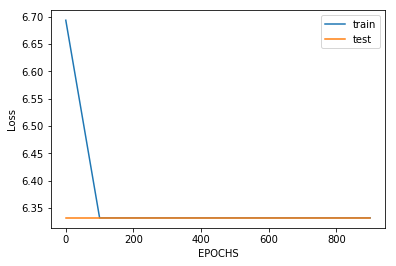

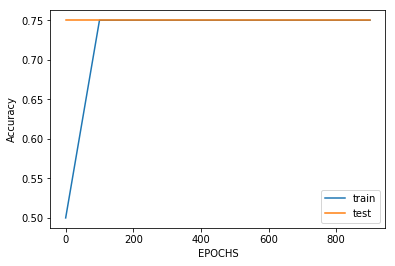

In [49]:
plot_loss(epoch_his,train_loss_his,test_loss_his)
plot_accuracy(epoch_his,train_acc_his,test_acc_his)

# Multiclass Classification (MNIST Data)

Now that we have implemented our own MLP we can use it to classify a real world dataset.

We will try to train our model to MNIST dataset.MNIST ("Modified National Institute of Standards and Technology") is the de facto “Hello World” dataset of computer vision. 

 
The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples.

You can download and checkout the various benchmarks at http://yann.lecun.com/exdb/mnist/ for MNIST.



![title](img/MnistExamples.png)

Example of some images in the dataset

But first we move further we will need to define some loss and metric functions for multiclass classifications.

### Loss Function

In [50]:

def softmax_multiclass_cross_entropy(pred ,Y):
    """
    The multiclass cross entropy loss with a softmax activation.
    Note
    -Use this loss when softmax(defined in [[Activations.py]]) is used as activation for the last layer.
    -pred should be in range [0,1]
    -Y should be Column vector of one hot row vectors
    Inputs
    -pred: a numpy array reprsenting predictions made by the model
    -Y : a numpy  array representing the target variable
    Note that shape(pred) = shape(Y)
    Returns
    - loss : a scalar value to represent the loss
    - d_pred : a vector of the same shape as pred. It represents the error
            to be used for backpropogation(shape(d_pred) = shape(pred))
    """
    epsilon = 1e-11
    pred = np.clip(pred , epsilon , 1 - epsilon)
    loss = np.mean(-np.sum(np.log(pred)*Y, axis = 1) , axis = 0)
    d_pred = pred - Y
    return loss,d_pred

### Metric Function

In [51]:
def accuracy_multiclass(pred, Y):
    """
    Computes the zero one accuracy for a Multiclass classificatiion
    Inputs:
    -pred: Column vector representing probabilities of Class == 1
    -Y: Column vector of one hot row vectors
    """
    #print("acc, pred = ",pred)
    #print("acc, Y = ",Y)
    acc = np.sum(pred.argmax(1)==Y.argmax(1))
    acc = float(acc) / len(Y)
    return acc

### Loading MNIST Data


Download the data from the following link : https://www.kaggle.com/c/digit-recognizer/data

In [52]:
import pandas as pd
import matplotlib.pyplot as plt

In [53]:
data = pd.read_csv('./train.csv')

In [54]:
Y = data['label']

X = data.drop('label' , axis = 1)

Now we can see the dimensions of the data . MNIST has 28 x 28 pixel grayscale images which when flattened(converted to 1D) gives 784 size vector

In [55]:
X.shape

(42000, 784)

In [56]:
Y.shape

(42000,)

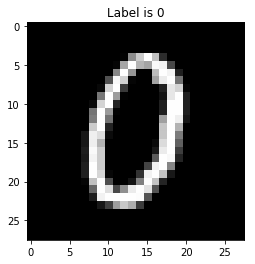

In [57]:
#lets try plotting a image

sample = 5 #try changing this number

number = X.iloc[sample].values.reshape((28, 28))
label = Y.iloc[sample]
# Plot
plt.title('Label is {label}'.format(label=label))
plt.imshow(number, cmap='gray')
plt.show()


Now that we know and understand the data lets us try to train our model

### Training Model

In [71]:
# we first split the data into training and validation set
from sklearn.model_selection import train_test_split
train_x , test_x, train_y , test_y = train_test_split(X.values , Y.values.reshape(-1,1), test_size = 0.2)


In [72]:
train_x.shape

(33600, 784)

In [73]:
train_y.shape

(33600, 1)

Now we understand the concepts of an MLP network we can work with the boiler plate algorithms provided by sklearn library. This in addition to the gradient descent algorithm provides us many other learning techninques. (adam , early stopping , etc)

You can read about these techniques more here : https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

In [93]:
from sklearn.neural_network import MLPClassifier


mlp = MLPClassifier(hidden_layer_sizes=(100,),
                          max_iter = 20,
                          verbose = True,
                          warm_start = True)


In [94]:
mlp.fit(train_x,train_y)

/home/mehul/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 3.37075558
Iteration 2, loss = 1.18247687
Iteration 3, loss = 0.74531228
Iteration 4, loss = 0.50335825
Iteration 5, loss = 0.35059299
Iteration 6, loss = 0.26323034
Iteration 7, loss = 0.19777507
Iteration 8, loss = 0.16725208
Iteration 9, loss = 0.12114521
Iteration 10, loss = 0.11010317
Iteration 11, loss = 0.09048285
Iteration 12, loss = 0.08700305
Iteration 13, loss = 0.07646963
Iteration 14, loss = 0.08262454
Iteration 15, loss = 0.06886162
Iteration 16, loss = 0.08321271
Iteration 17, loss = 0.08342101
Iteration 18, loss = 0.08577355
Iteration 19, loss = 0.08421365
Iteration 20, loss = 0.09809289


/home/mehul/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=20, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=True, warm_start=True)

In [97]:
print("Training set score: %f" % mlp.score(train_x, train_y))
print("Test set score: %f" % mlp.score(test_x, test_y))

Training set score: 0.982530
Test set score: 0.940952


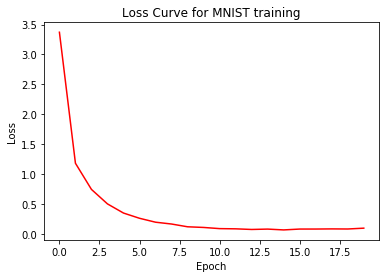

In [98]:
plt.title("Loss Curve for MNIST training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(mlp.loss_curve_ ,c='red' , linestyle='-')
plt.show()

In [104]:
from sklearn.model_selection import validation_curve

train_scores, valid_scores = validation_curve(mlp, X.values , Y.values, "alpha",
                                             np.logspace(-7, 3, 3),
                                             cv = 5)

Iteration 1, loss = 3.32190393
Iteration 2, loss = 1.23004501
Iteration 3, loss = 0.76423016
Iteration 4, loss = 0.52601689
Iteration 5, loss = 0.37529255
Iteration 6, loss = 0.28113889
Iteration 7, loss = 0.20027362
Iteration 8, loss = 0.16095822
Iteration 9, loss = 0.13000480
Iteration 10, loss = 0.10941213
Iteration 11, loss = 0.10947414
Iteration 12, loss = 0.10315081
Iteration 13, loss = 0.09649289
Iteration 14, loss = 0.08809384
Iteration 15, loss = 0.07920882
Iteration 16, loss = 0.08814944
Iteration 17, loss = 0.08578018
Iteration 18, loss = 0.07795269
Iteration 19, loss = 0.06320344
Iteration 20, loss = 0.07418372


/home/mehul/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 3.12615919
Iteration 2, loss = 1.19736202
Iteration 3, loss = 0.74540280
Iteration 4, loss = 0.49326351
Iteration 5, loss = 0.36001031
Iteration 6, loss = 0.29265278
Iteration 7, loss = 0.22179947
Iteration 8, loss = 0.18162449
Iteration 9, loss = 0.14612336
Iteration 10, loss = 0.13443013
Iteration 11, loss = 0.11666226
Iteration 12, loss = 0.11840761
Iteration 13, loss = 0.09666847
Iteration 14, loss = 0.10652509
Iteration 15, loss = 0.10278218
Iteration 16, loss = 0.09984719
Iteration 17, loss = 0.10161049
Iteration 18, loss = 0.08423936
Iteration 19, loss = 0.08264365
Iteration 20, loss = 0.08019883


/home/mehul/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 158.86265507
Iteration 2, loss = 18.43170736
Iteration 3, loss = 3.89177307
Iteration 4, loss = 1.48056180
Iteration 5, loss = 0.94970118
Iteration 6, loss = 0.80454277
Iteration 7, loss = 0.75832748
Iteration 8, loss = 0.74127527
Iteration 9, loss = 0.73898294
Iteration 10, loss = 0.73556523
Iteration 11, loss = 0.73912212
Iteration 12, loss = 0.74506588
Iteration 13, loss = 0.74404369
Iteration 14, loss = 0.74361763
Iteration 15, loss = 0.74673502
Iteration 16, loss = 0.74496054
Iteration 17, loss = 0.75237604
Iteration 18, loss = 0.75026531
Iteration 19, loss = 0.76564448
Iteration 20, loss = 0.76299827


/home/mehul/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 3.17554554
Iteration 2, loss = 0.98054186
Iteration 3, loss = 0.56436018
Iteration 4, loss = 0.38711749
Iteration 5, loss = 0.29183833
Iteration 6, loss = 0.22322722
Iteration 7, loss = 0.18542233
Iteration 8, loss = 0.15496013
Iteration 9, loss = 0.13669859
Iteration 10, loss = 0.12062791
Iteration 11, loss = 0.11277069
Iteration 12, loss = 0.10427345
Iteration 13, loss = 0.09423774
Iteration 14, loss = 0.08879865
Iteration 15, loss = 0.09682402
Iteration 16, loss = 0.09701501
Iteration 17, loss = 0.08103394
Iteration 18, loss = 0.07730601
Iteration 19, loss = 0.08274607
Iteration 20, loss = 0.08360765


/home/mehul/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 3.23523720
Iteration 2, loss = 1.23534913
Iteration 3, loss = 0.77347812
Iteration 4, loss = 0.54723775
Iteration 5, loss = 0.37739762
Iteration 6, loss = 0.29234609
Iteration 7, loss = 0.22238248
Iteration 8, loss = 0.17366644
Iteration 9, loss = 0.14852254
Iteration 10, loss = 0.12480919
Iteration 11, loss = 0.11486171
Iteration 12, loss = 0.09483026
Iteration 13, loss = 0.09033237
Iteration 14, loss = 0.10604274
Iteration 15, loss = 0.12795319
Iteration 16, loss = 0.10580285
Iteration 17, loss = 0.07915679
Iteration 18, loss = 0.08233263
Iteration 19, loss = 0.06554927
Iteration 20, loss = 0.08571742


/home/mehul/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 147.71136797
Iteration 2, loss = 13.16939144
Iteration 3, loss = 2.62921594
Iteration 4, loss = 1.09627018
Iteration 5, loss = 0.80949760
Iteration 6, loss = 0.75179238
Iteration 7, loss = 0.74191381
Iteration 8, loss = 0.73592825
Iteration 9, loss = 0.74561402
Iteration 10, loss = 0.74136582
Iteration 11, loss = 0.74298259
Iteration 12, loss = 0.74311858
Iteration 13, loss = 0.74880072
Iteration 14, loss = 0.75468715
Iteration 15, loss = 0.75445198
Iteration 16, loss = 0.75738483
Iteration 17, loss = 0.76939660
Iteration 18, loss = 0.76594013
Iteration 19, loss = 0.76345774
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 3.20141985
Iteration 2, loss = 1.06090108
Iteration 3, loss = 0.59981883
Iteration 4, loss = 0.40279962
Iteration 5, loss = 0.30573177
Iteration 6, loss = 0.24046724
Iteration 7, loss = 0.19919113
Iteration 8, loss = 0.17387092
Iteration 9, loss = 0.15522299
Iteration 10, loss = 0.136115

/home/mehul/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 3.17606565
Iteration 2, loss = 1.30043816
Iteration 3, loss = 0.78885539
Iteration 4, loss = 0.52768099
Iteration 5, loss = 0.37804325
Iteration 6, loss = 0.27782797
Iteration 7, loss = 0.21185210
Iteration 8, loss = 0.17203077
Iteration 9, loss = 0.24012432
Iteration 10, loss = 0.14171834
Iteration 11, loss = 0.27298994
Iteration 12, loss = 0.14697043
Iteration 13, loss = 0.10959727
Iteration 14, loss = 0.08076941
Iteration 15, loss = 0.08102576
Iteration 16, loss = 0.06596166
Iteration 17, loss = 0.08211184
Iteration 18, loss = 0.08328703
Iteration 19, loss = 0.08025026
Iteration 20, loss = 0.07788298


/home/mehul/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 157.27953441
Iteration 2, loss = 17.42312188
Iteration 3, loss = 7.70512634
Iteration 4, loss = 4.39115108
Iteration 5, loss = 2.94444032
Iteration 6, loss = 2.30139403
Iteration 7, loss = 1.81546598
Iteration 8, loss = 1.19894947
Iteration 9, loss = 1.14447586
Iteration 10, loss = 1.16861919
Iteration 11, loss = 1.26571757
Iteration 12, loss = 1.21854633
Iteration 13, loss = 1.28612069
Iteration 14, loss = 1.32399457
Iteration 15, loss = 1.30517812
Iteration 16, loss = 1.34725132
Iteration 17, loss = 1.35584923
Iteration 18, loss = 1.40323069
Iteration 19, loss = 1.34312941
Iteration 20, loss = 1.56190405
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 3.34291759
Iteration 2, loss = 1.27677346
Iteration 3, loss = 0.81634392
Iteration 4, loss = 0.58230567
Iteration 5, loss = 0.41625777
Iteration 6, loss = 0.31579979
Iteration 7, loss = 0.26190792
Iteration 8, loss = 0.23533606
Iteration 9, loss = 0.331643

/home/mehul/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 3.45112328
Iteration 2, loss = 1.27924600
Iteration 3, loss = 0.85640866
Iteration 4, loss = 0.56825276
Iteration 5, loss = 0.39914293
Iteration 6, loss = 0.28384334
Iteration 7, loss = 0.21168663
Iteration 8, loss = 0.17885657
Iteration 9, loss = 0.14283412
Iteration 10, loss = 0.11513673
Iteration 11, loss = 0.11397169
Iteration 12, loss = 0.10969564
Iteration 13, loss = 0.10261372
Iteration 14, loss = 0.09132516
Iteration 15, loss = 0.08243521
Iteration 16, loss = 0.07308942
Iteration 17, loss = 0.07607719
Iteration 18, loss = 0.08450809
Iteration 19, loss = 0.08520602
Iteration 20, loss = 0.08758982


/home/mehul/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 148.71002870
Iteration 2, loss = 11.45140028
Iteration 3, loss = 3.63635786
Iteration 4, loss = 1.60236959
Iteration 5, loss = 1.00763749
Iteration 6, loss = 0.85909470
Iteration 7, loss = 0.83133143
Iteration 8, loss = 0.82390428
Iteration 9, loss = 0.88917456
Iteration 10, loss = 0.84643418
Iteration 11, loss = 0.82661976
Iteration 12, loss = 0.84745535
Iteration 13, loss = 0.84796359
Iteration 14, loss = 0.84179546
Iteration 15, loss = 0.89007243
Iteration 16, loss = 0.85512140
Iteration 17, loss = 0.88787749
Iteration 18, loss = 0.85947059
Iteration 19, loss = 0.88915242
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 3.50642420
Iteration 2, loss = 1.26959156
Iteration 3, loss = 0.74831243
Iteration 4, loss = 0.49515661
Iteration 5, loss = 0.37029744
Iteration 6, loss = 0.28827531
Iteration 7, loss = 0.22877790
Iteration 8, loss = 0.19463111
Iteration 9, loss = 0.17329561
Iteration 10, loss = 0.152566

/home/mehul/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 3.23808765
Iteration 2, loss = 1.18941565
Iteration 3, loss = 0.72215824
Iteration 4, loss = 0.51825448
Iteration 5, loss = 0.34622314
Iteration 6, loss = 0.28435366
Iteration 7, loss = 0.21825689
Iteration 8, loss = 0.18445590
Iteration 9, loss = 0.18251515
Iteration 10, loss = 0.15743551
Iteration 11, loss = 0.15182104
Iteration 12, loss = 0.12548725
Iteration 13, loss = 0.10186791
Iteration 14, loss = 0.09248259
Iteration 15, loss = 0.08859800
Iteration 16, loss = 0.08314545
Iteration 17, loss = 0.10150961
Iteration 18, loss = 0.09444548
Iteration 19, loss = 0.07712473
Iteration 20, loss = 0.08174736


/home/mehul/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 164.06875072
Iteration 2, loss = 19.21324975
Iteration 3, loss = 5.30040501
Iteration 4, loss = 2.17992233
Iteration 5, loss = 1.20571758
Iteration 6, loss = 0.88845108
Iteration 7, loss = 0.79309721
Iteration 8, loss = 0.77234672
Iteration 9, loss = 0.76932141
Iteration 10, loss = 0.77666512
Iteration 11, loss = 0.78399435
Iteration 12, loss = 0.78109519
Iteration 13, loss = 0.79588330
Iteration 14, loss = 0.83152355
Iteration 15, loss = 0.80448569
Iteration 16, loss = 0.79585610
Iteration 17, loss = 0.80066198
Iteration 18, loss = 0.81042721


/home/mehul/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


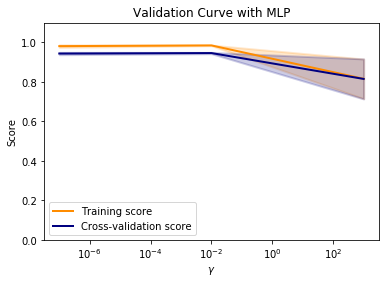

In [107]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(valid_scores, axis=1)
test_scores_std = np.std(valid_scores, axis=1)


param_range = np.logspace(-7, 3, 3)



plt.title("Validation Curve with MLP")
plt.xlabel(r"$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

## Visualising Weights of the MLP

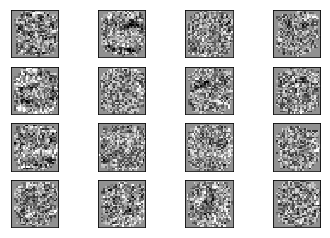

In [100]:
fig, axes = plt.subplots(4, 4)
# use global min / max to ensure all weights are shown on the same scale
vmin, vmax = mlp.coefs_[0].min(), mlp.coefs_[0].max()
for coef, ax in zip(mlp.coefs_[0].T, axes.ravel()):
    ax.matshow(coef.reshape(28, 28), cmap=plt.cm.gray, vmin=.5 * vmin,
               vmax=.5 * vmax)
    ax.set_xticks(())
    ax.set_yticks(())

plt.show()